# CAPTCHA OCR — EDA & Preprocessing Walkthrough 

**Project context & goals**

- Purpose: This notebook documents the data pipeline for CAPTCHA OCR using a CNN+BiLSTM+CTC model. It covers:
	-	Dataset discovery and label extraction from filenames
	-	Vocabulary building and max sequence length
	-	Image transforms & label encoding
	-	Train/val split and augmentation
	-	Model shape expectations & metrics (CER/WER)
	- 	Training callbacks and logging

- Why this matters
    - OCR pipelines are brittle to preprocessing. This notebook explains why we resize, normalize, index labels, and use CTC — and how to interpret CER/WER and training logs during development.

## Imports & environment checks

- Explanation
	-	DataProvider is the input pipeline that batches images + labels.
	-	CTCloss + CWERMetric (Character/Word Error Rate) are sequence-to-sequence metrics for OCR.
	-	The transforms (ImageResizer, LabelIndexer, LabelPadding) ensure inputs conform to model shape & CTC expectations.
	-	The augmentors simulate real OCR noise (brightness, rotation, morphology).
	-	residual_block is used to build a ResNet-ish conv stack before BiLSTM.

In [ ]:
# Core
import os
from pathlib import Path
from collections import Counter

# Data & viz
import numpy as np
import pandas as pd
from PIL import Image

# ML tooling (TensorFlow / Keras)
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard


# mltu: provider, losses, metrics, callbacks, transforms, augmentors
from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.metrics import CWERMetric
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.preprocessors import ImageReader
from mltu.annotations.images import CVImage
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate
from mltu.tensorflow.model_utils import residual_block

print("NumPy:", np.__version__)
print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

NumPy: 1.26.4
TF: 2.16.2
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Configuration object

Centralized config keeps experiments reproducible and paths consistent. The image size (50×200) and batch size (64) are aligned with the CNN+BiLSTM architecture and CTC time-steps later.

In [82]:
# configs.py
import stow
from datetime import datetime

from mltu.configs import BaseModelConfigs

class ModelConfigs(BaseModelConfigs):
    def __init__(self):
        super().__init__()
        self.model_path = stow.join('Models/02_captcha_to_text', datetime.strftime(datetime.now(), "%Y%m%d%H%M"))
        self.vocab = ''
        self.height = 50
        self.width = 200
        self.max_text_length = 0
        self.batch_size = 64
        self.learning_rate = 1e-3
        self.train_epochs = 70
        self.train_workers = 20

## Dataset

In [83]:
import os
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

In [84]:
def download_and_unzip(url, extract_to='Datasets'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)


In [3]:
if not os.path.exists(os.path.join("Datasets", "captcha_images_v2")):
    download_and_unzip("https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip",
                       extract_to="Datasets")

### Dataset discovery & label derivation

- Explanation
	-	Labels are derived from filename stems (i.e., text before the extension) — e.g., 4h2d9.png → "4h2d9".
	-	We also compute character vocabulary and max sequence length required by CTC.
	-	This approach: collect path + filename, build vocab from p.stem, track max_len.  ￼

- Output to look for
	-	len(dataset): number of samples
	-	configs.vocab: sorted string of unique characters (e.g., digits+letters)
	-	configs.max_text_length: longest CAPTCHA text length found

In [85]:
root = Path("Datasets/captcha_images_v2")
image_exts = {".png", ".jpg", ".jpeg", ".bmp", ".webp"}

dataset, vocab, max_len = [], set(), 0

for p in sorted(root.rglob("*")):
    if p.suffix.lower() in image_exts and p.is_file():
        dataset.append([str(p.resolve()), p.name])
        # If the label is the filename (without extension), use stem:
        vocab.update(list(p.stem))
        max_len = max(max_len, len(p.stem))

configs = ModelConfigs()
configs.vocab = "".join(sorted(vocab))   # keep it deterministic
configs.max_text_length = max_len
configs.save()

## EDA

**What this section does**
- Scans dataset structure & filetypes
- Extracts labels from filename *stems* (not extensions)
- Audits label lengths and character set
- Shows random image montage to eyeball quality/cropping
- Plots image size distributions and grayscale histograms
- Finds exact duplicate files by content hash (leakage risk)

**Why it matters**
OCR with CNN→BiLSTM→CTC is very sensitive to preprocessing choices (resize, vocab, padding). This EDA validates that our dataset assumptions match our training pipeline (resize to 200×50; label indexing/padding; augmentations).  

### Paths, knobs, imports

In [ ]:
from pathlib import Path
import os, random, math, hashlib, statistics
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# ---- EDA config ----
DATA_ROOT = Path("Datasets/captcha_images_v2")   
EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".webp"}
RANDOM_SEED = 42

# Sampling to keep EDA fast on large datasets
MAX_FOR_SIZE_SCAN   = 5000    # images to sample for size stats (None = all)
MAX_FOR_HISTOGRAMS  = 2000    # images to sample for intensity histograms
MONTAGE_COUNT       = 36      # images in montage (e.g., 6x6)
TOP_CHAR_N          = 40      # show top-N characters in frequency plot

random.seed(RANDOM_SEED)

print("DATA_ROOT:", DATA_ROOT.resolve())
print("Extensions:", sorted(EXTS))

DATA_ROOT: /Users/tiyanigurusinghe/Desktop/Projects/Captcha Solver/Datasets/captcha_images_v2
Extensions: ['.bmp', '.jpeg', '.jpg', '.png', '.webp']


### Discover image files

In [89]:
# Recursively gather images
all_files = [p for p in DATA_ROOT.rglob("*") if p.suffix.lower() in EXTS and p.is_file()]

eda_df = pd.DataFrame({
    "path": [str(p) for p in all_files],
    "file": [p.name for p in all_files],
    "stem": [p.stem for p in all_files],   # <-- label candidate
    "ext":  [p.suffix.lower() for p in all_files],
})

print(f"Found {len(eda_df)} image files.")
eda_df.head(10)

Found 1040 image files.


,path,file,stem,ext
0,Datasets/captcha_images_v2/p5g5m.png,p5g5m.png,p5g5m,.png
1,Datasets/captcha_images_v2/e72cd.png,e72cd.png,e72cd,.png
2,Datasets/captcha_images_v2/pgmn2.png,pgmn2.png,pgmn2,.png
3,Datasets/captcha_images_v2/6cm6m.png,6cm6m.png,6cm6m,.png
4,Datasets/captcha_images_v2/68wfd.png,68wfd.png,68wfd,.png
5,Datasets/captcha_images_v2/byc82.png,byc82.png,byc82,.png
6,Datasets/captcha_images_v2/gcx6f.png,gcx6f.png,gcx6f,.png
7,Datasets/captcha_images_v2/d8dce.png,d8dce.png,d8dce,.png
8,Datasets/captcha_images_v2/gd4mf.png,gd4mf.png,gd4mf,.png
9,Datasets/captcha_images_v2/fy2nd.png,fy2nd.png,fy2nd,.png


### Filetype mix & quick counts

In [90]:
by_ext = eda_df['ext'].value_counts().rename_axis('ext').reset_index(name='count')
display(by_ext)

print("Total images:", len(eda_df))
print("Unique stems (label candidates):", eda_df['stem'].nunique())
print("Same label across multiple extensions:",
      (eda_df.groupby('stem')['ext'].nunique() > 1).sum())

,ext,count
0,.png,1040


Total images: 1040
Unique stems (label candidates): 1040
Same label across multiple extensions: 0


### Label length & charset audits

In [91]:
label_lengths = eda_df['stem'].map(len)

length_stats = {
    "count": int(label_lengths.count()),
    "min_len": int(label_lengths.min()) if len(label_lengths) else None,
    "max_len": int(label_lengths.max()) if len(label_lengths) else None,
    "median_len": float(label_lengths.median()) if len(label_lengths) else None,
    "mean_len": float(label_lengths.mean()) if len(label_lengths) else None,
}
pd.DataFrame(length_stats, index=['value']).T

,value
count,1040.0
min_len,5.0
max_len,5.0
median_len,5.0
mean_len,5.0


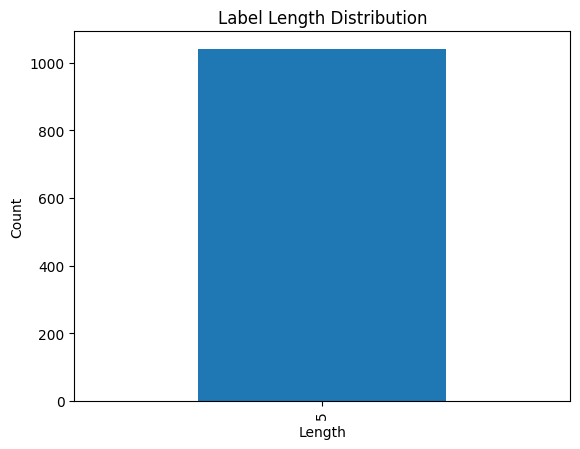

In [93]:
 # Distribution of label lengths
vc = label_lengths.value_counts().sort_index()
plt.figure()
vc.plot(kind='bar', title='Label Length Distribution')
plt.xlabel('Length'); plt.ylabel('Count')
plt.show()

,char,count
0,n,525
1,4,284
2,5,281
3,m,275
4,f,271
5,g,271
6,3,267
7,2,265
8,8,264
9,x,264


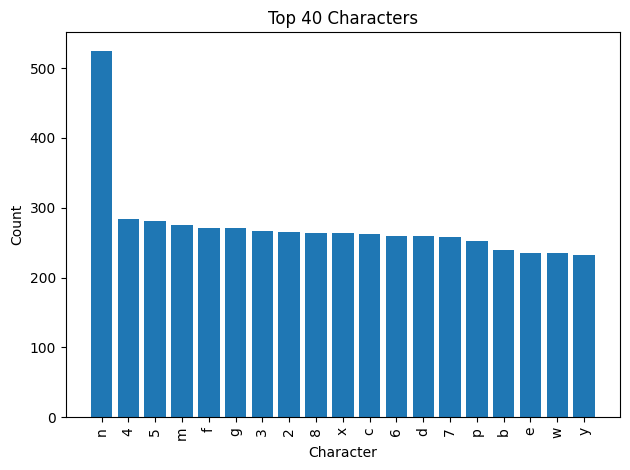

In [92]:
# Character frequency
chars = Counter("".join(eda_df['stem'].tolist()))
char_df = pd.DataFrame(sorted(chars.items(), key=lambda x: (-x[1], x[0])), columns=['char','count'])
display(char_df.head(20))

topn = char_df.head(TOP_CHAR_N)
plt.figure()
plt.bar(topn['char'].astype(str), topn['count'])
plt.title(f'Top {TOP_CHAR_N} Characters')
plt.xlabel('Character'); plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Label integrity checks

In [94]:
import string

def check_label(s: str):
    issues = []
    if len(s) == 0:
        issues.append("EMPTY")
    if any(ch.isspace() for ch in s):
        issues.append("HAS_SPACE")
    if any(ch in set(string.punctuation) for ch in s):
        issues.append("HAS_PUNCT")
    try:
        s.encode('ascii')
    except UnicodeEncodeError:
        issues.append("NON_ASCII")
    return issues

eda_df['label_issues'] = eda_df['stem'].map(check_label)
problems = eda_df[eda_df['label_issues'].map(len) > 0]
print(f"Labels with issues: {len(problems)} / {len(eda_df)}")
problems.head(20)

Labels with issues: 0 / 1040


,path,file,stem,ext,label_issues


### Random montage (visual spot-check)

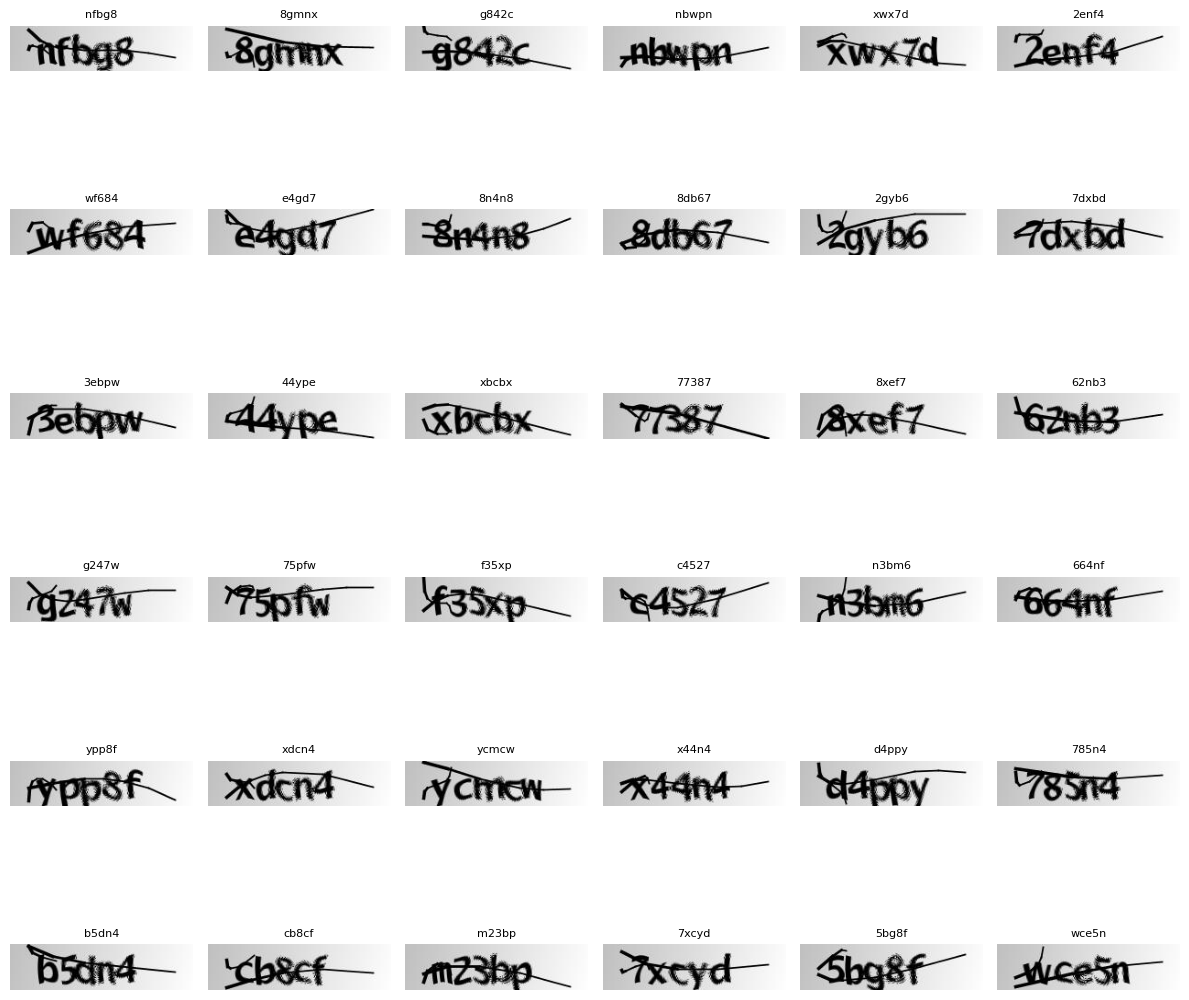

In [95]:
def show_montage(paths, cols=6, size=(200, 50)):
    rows = math.ceil(len(paths)/cols)
    plt.figure(figsize=(cols*2, rows*2))
    for i, p in enumerate(paths[:cols*rows]):
        try:
            img = Image.open(p).convert("RGB")
        except Exception:
            img = Image.new('RGB', size, (255,0,0))
        img = ImageOps.contain(img, size)
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_title(Path(p).stem, fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_paths = random.sample(eda_df['path'].tolist(), min(MONTAGE_COUNT, len(eda_df)))
show_montage(sample_paths, cols=6, size=(200, 50))

### Image size distribution

Samples scanned: 1040
Width  min/median/mean/max: 200 200.0 200.0 200
Height min/median/mean/max: 50 50.0 50.0 50


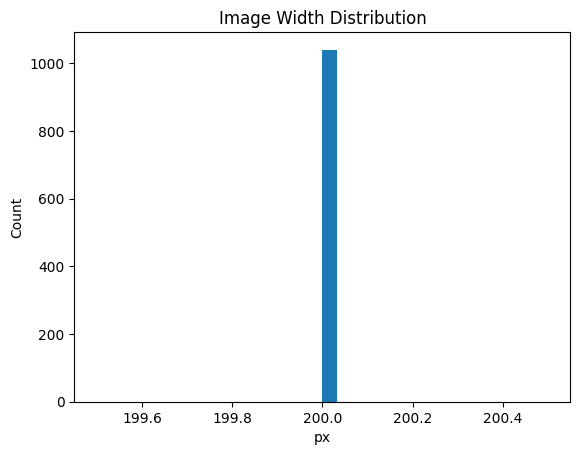

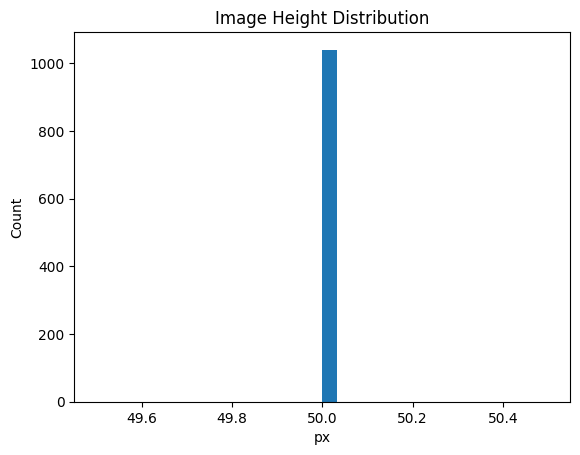

In [ ]:
def safe_open_size(path):
    try:
        with Image.open(path) as im:
            im.load()
            return im.size  # (W, H)
    except Exception:
        return None

paths_for_size = eda_df['path'].tolist()
if MAX_FOR_SIZE_SCAN is not None:
    paths_for_size = random.sample(paths_for_size, min(MAX_FOR_SIZE_SCAN, len(paths_for_size)))

sizes = [safe_open_size(p) for p in paths_for_size]
sizes = [s for s in sizes if s is not None]

if sizes:
    widths  = [w for (w,h) in sizes]
    heights = [h for (w,h) in sizes]

    print("Samples scanned:", len(sizes))
    print("Width  min/median/mean/max:", min(widths), np.median(widths), round(np.mean(widths),2), max(widths))
    print("Height min/median/mean/max:", min(heights), np.median(heights), round(np.mean(heights),2), max(heights))

    plt.figure(); plt.hist(widths, bins=30);  plt.title("Image Width Distribution");  plt.xlabel("px"); plt.ylabel("Count"); plt.show()
    plt.figure(); plt.hist(heights, bins=30); plt.title("Image Height Distribution"); plt.xlabel("px"); plt.ylabel("Count"); plt.show()
else:
    print("No valid images opened for size scan.")

### Exact duplicate detection

In [97]:
def file_md5(path, chunk=8192):
    try:
        h = hashlib.md5()
        with open(path, 'rb') as f:
            for block in iter(lambda: f.read(chunk), b""):
                h.update(block)
        return h.hexdigest()
    except Exception:
        return None

hash_map = defaultdict(list)
for p in eda_df['path']:
    h = file_md5(p)
    if h:
        hash_map[h].append(p)

dupe_groups = [v for v in hash_map.values() if len(v) > 1]
print(f"Duplicate groups (exact content match): {len(dupe_groups)}")
if dupe_groups:
    for i, g in enumerate(dupe_groups[:3], 1):
        print(f"Group {i}:")
        for p in g[:8]:
            print("  ", p)
        if len(g) > 8:
            print("  ...")

Duplicate groups (exact content match): 0


-	Length distribution: confirm most CAPTCHAs share a common length (e.g., 4–6). If there’s a long tail, consider truncation or curriculum.
-	Charset: identify unexpected chars (e.g., confusing O/0, l/1). Decide whether to normalize or keep.
-	Data integrity: verify no empty labels and no outlier lengths beyond configs.max_text_length.

,value
n_images,1040.0
min_len,5.0
max_len,5.0
median_len,5.0
unique_chars,19.0


Top 20 chars: [('n', 525), ('4', 284), ('5', 281), ('m', 275), ('g', 271), ('f', 271), ('3', 267), ('2', 265), ('8', 264), ('x', 264), ('c', 262), ('6', 259), ('d', 259), ('7', 258), ('p', 253), ('b', 240), ('e', 235), ('w', 235), ('y', 232)]


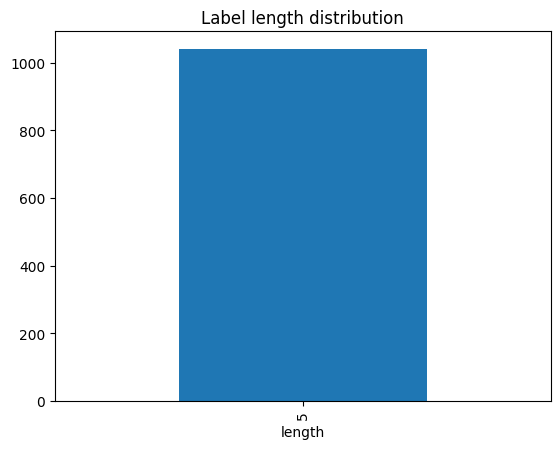

In [86]:
labels = [Path(row[1]).stem for row in dataset]
lengths = pd.Series([len(s) for s in labels], name="length")
chars = Counter("".join(labels))

display(pd.DataFrame({
    "n_images": [len(labels)],
    "min_len": [lengths.min()],
    "max_len": [lengths.max()],
    "median_len": [lengths.median()],
    "unique_chars": [len(chars)],
}).T.rename(columns={0:"value"}))

print("Top 20 chars:", Counter("".join(labels)).most_common(20))
lengths.value_counts().sort_index().plot(kind="bar", title="Label length distribution");

#### Save configs snapshot (for reproducibility)

In [87]:
configs.save()

# Modelling

## 1. Data Provider Setup

The pipeline uses the **`mltu` framework’s `DataProvider`** class to manage image–label pairs efficiently.  
This ensures each training batch contains correctly preprocessed and tokenized CAPTCHA images.


#### Key Components


- **`dataset`**: A list of `[image_path, label]` pairs generated from the dataset directory (`Datasets/captcha_images_v2`).  
  Each label is derived from the filename (e.g., `3x7h.png → "3x7h"`).

- **`vocab`**:  
  Constructed dynamically from all unique characters across labels.  
  This ensures the model learns the complete alphabet used in the CAPTCHA set.

- **`configs` object**:  
  A configuration container storing model hyperparameters, image dimensions, learning rate, and vocabulary mapping.

### Data Preprocessing & Transformation
Each image passes through the following sequence:

| Step | Transformer | Purpose |
|------|--------------|---------|
| 1️ | ImageReader(CVImage) | Reads the image file from disk and converts it into a compatible tensor format. |
| 2️ | ImageResizer(configs.width, configs.height) | Resizes all images to a uniform shape `(200×50)` for consistent batch processing. |
| 3️ | LabelIndexer(configs.vocab) | Encodes character sequences into integer indices based on the vocabulary. |
| 4️ | LabelPadding(max_word_length) | Ensures uniform label lengths by padding shorter labels with a neutral value. |

*Note:* Normalization (dividing pixel values by 255) is intentionally done inside the model to maintain flexibility in the input pipeline.

In [10]:
data_provider = DataProvider(
    dataset=dataset,
    skip_validation=True,
    batch_size=configs.batch_size,
    data_preprocessors=[ImageReader(CVImage)],
    transformers=[
        ImageResizer(configs.width, configs.height),
        LabelIndexer(configs.vocab),
        LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab))
        ],
)

## 2. Dataset Splitting and Augmentation



The dataset is split into:

- **Training Set (90%)** – for learning.
- **Validation Set (10%)** – for monitoring performance.

To improve generalization, several **on-the-fly augmentations** are applied to the training images:

| Augmentor | Effect |
|------------|--------|
| RandomBrightness() | Varies brightness to mimic lighting differences. |
| RandomRotate() | Randomly rotates images to enhance rotational invariance. |
| RandomErodeDilate() | Applies morphological changes, simulating font thickness variation and noise. |

These augmentations make the model robust to distortions and visually diverse inputs — common in real CAPTCHA challenges.

In [11]:
# Split the dataset into training and validation sets
train_data_provider, val_data_provider = data_provider.split(split = 0.9)

# Augment training data with random brightness, rotation and erode/dilate
train_data_provider.augmentors = [RandomBrightness(), RandomRotate(), RandomErodeDilate()]

## 3. Model Architecture: Residual CNN + BiLSTM


The model combines **Convolutional Neural Networks (CNNs)** for visual feature extraction with **Bidirectional LSTMs** for sequence modeling — a common architecture for OCR-style tasks.

### CNN Backbone (Feature Extraction)

- The input passes through **residual blocks** defined via `mltu.tensorflow.model_utils.residual_block`.  
- These blocks consist of:
  - `Conv2D` layers with *LeakyReLU* activation.  
  - Batch normalization and skip connections to improve gradient flow.
  - Occasional downsampling (stride=2) to reduce spatial resolution progressively.

### Temporal Encoding with BiLSTM

After feature extraction:
- The 3D tensor is **reshaped** into a sequence format (flattening spatial dimensions).
- A **Bidirectional LSTM (128 units)** models temporal dependencies across image columns.
  - This helps the network interpret character sequences as ordered text.

#### Output Layer

- A **Dense layer** produces softmax probabilities across `(len(vocab) + 1)` tokens.  
  The extra token represents the *CTC blank label* used by the decoder.

**Summary:**  
Each residual block adds representational power while maintaining computational efficiency, enabling the model to handle varied CAPTCHA fonts and backgrounds.

In [98]:
def train_model(input_dim, output_dim, activation="leaky_relu", dropout=0.2):
    
    inputs = layers.Input(shape=input_dim, name="input")

    # normalize images here instead in preprocessing step
    input = layers.Lambda(lambda x: x / 255)(inputs)

    x1 = residual_block(input, 16, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x2 = residual_block(x1, 16, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x3 = residual_block(x2, 16, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x4 = residual_block(x3, 32, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x5 = residual_block(x4, 32, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x6 = residual_block(x5, 64, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x7 = residual_block(x6, 32, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x8 = residual_block(x7, 64, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x9 = residual_block(x8, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    squeezed = layers.Reshape((x9.shape[-3] * x9.shape[-2], x9.shape[-1]))(x9)

    blstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(squeezed)
    blstm = layers.Dropout(dropout)(blstm)

    output = layers.Dense(output_dim + 1, activation="softmax", name="output")(blstm)

    model = Model(inputs=inputs, outputs=output)
    return model

In [99]:
# Creating TensorFlow model architecture
model = train_model(
    input_dim = (configs.height, configs.width, 3),
    output_dim = len(configs.vocab),
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


## 4. Model Compilation

The model is compiled with the following configuration:

| Component | Description |
|------------|-------------|
| **Optimizer** | Adam(learning_rate=configs.learning_rate) — efficient adaptive optimizer for faster convergence. |
| **Loss** | CTCloss() — Connectionist Temporal Classification loss aligns input-output sequences without explicit character segmentation. |
| **Metric** | CWERMetric() — computes Character Error Rate (CER) and Word Error Rate (WER), providing interpretable accuracy measures. |

*Why CTC?*  
CTC is essential in OCR-like problems where character boundaries are unknown.  
It allows the network to learn flexible alignments between image sequences and label strings.

In [15]:
import os
# Compile the model and print summary
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate), 
    loss=CTCloss(), 
    metrics=[CWERMetric(padding_token=len(configs.vocab))],
    run_eagerly=False
)
model.summary(line_length=110)
# Define path to save the model
os.makedirs(configs.model_path, exist_ok=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape              ┃          Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)             │ (None, 50, 200, 3)        │                0 │ -                          │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ lambda (Lambda)                │ (None, 50, 200, 3)        │                0 │ input[0][0]                │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2d (Conv2D)                │ (None, 50, 200, 16)       │              448 │ lambda[0][0]               │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ batch_normalization            │ (None, 50, 200, 16)       │               64 │ conv2d[0][0]               │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)        │ (None, 50, 200, 16)       │                0 │ batch_normalization[0][0]  │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)              │ (None, 50, 200, 16)       │            2,320 │ leaky_re_lu[0][0]          │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ batch_normalization_1          │ (None, 50, 200, 16)       │               64 │ conv2d_1[0][0]             │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)              │ (None, 50, 200, 16)       │               64 │ lambda[0][0]               │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ add (Add)                      │ (None, 50, 200, 16)       │                0 │ batch_normalization_1[0][… │
│                                │                           │                  │ conv2d_2[0][0]             │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)      │ (None, 50, 200, 16)       │                0 │ add[0][0]                  │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ dropout (Dropout)              │ (None, 50, 200, 16)       │                0 │ leaky_re_lu_1[0][0]        │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)              │ (None, 25, 100, 16)       │            2,320 │ dropout[0][0]              │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ batch_normalization_2          │ (None, 25, 100, 16)       │               64 │ conv2d_3[0][0]             │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU)      │ (None, 25, 100, 16)       │                0 │ batch_normalization_2[0][… │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)              │ (None, 25, 100, 16)       │            2,320 │ leaky_re_lu_2[0][0]        │
├───

 Total params: 469,492 (1.79 MB)

 Trainable params: 468,148 (1.79 MB)

 Non-trainable params: 1,344 (5.25 KB)

## 5. Model Callbacks and Checkpoints

To automate and stabilize training, several callbacks are defined:

| Callback | Function |
|-----------|-----------|
| **EarlyStopping** | Monitors `val_CER` and halts training if it fails to improve for several epochs, preventing overfitting. |
| **ModelCheckpoint** | Saves model weights whenever validation CER improves. |
| **TrainLogger** | Logs training metrics to CSV for post-analysis. |
| **ReduceLROnPlateau** | Gradually reduces learning rate if validation metrics stagnate. |
| **TensorBoard** | Enables live visualization of losses and metrics. |
| **Model2onnx** | Converts the trained `.h5` model to ONNX format for cross-platform deployment. |

All checkpoints and logs are saved under: Models/02_captcha_to_text//

In [20]:
# Define callbacks
earlystopper = EarlyStopping(monitor="val_CER", patience=50, verbose=1, mode="min")
checkpoint = ModelCheckpoint(f"{configs.model_path}/model.h5", monitor="val_CER", verbose=1, save_best_only=True, mode="min")
trainLogger = TrainLogger(configs.model_path)
tb_callback = TensorBoard(f"{configs.model_path}/logs", update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor="val_CER", factor=0.9, min_delta=1e-10, patience=20, verbose=1, mode="min")
model2onnx = Model2onnx(f"{configs.model_path}/model.h5")


## 6. Model Training

In [22]:
# Train the model
model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    epochs=configs.train_epochs,
    callbacks=[earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback, model2onnx]
)

Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - CER: 1.0183 - WER: 1.0000 - loss: 16.2476
Epoch 1: val_CER improved from None to 1.01798, saving model to Models/02_captcha_to_text/202510191404/model.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 877ms/step - CER: 1.0180 - WER: 1.0000 - loss: 16.2451 - val_CER: 1.0180 - val_WER: 1.0000 - val_loss: 16.3804 - learning_rate: 0.0010
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - CER: 1.0177 - WER: 1.0000 - loss: 16.2127
Epoch 2: val_CER improved from 1.01798 to 1.01736, saving model to Models/02_captcha_to_text/202510191404/model.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 896ms/step - CER: 1.0174 - WER: 1.0000 - loss: 16.2148 - val_CER: 1.0174 - val_WER: 1.0000 - val_loss: 16.3259 - learning_rate: 0.0010
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - CER: 1.0170 - WER: 1.0000 - loss: 16.1842
Epoch 3: val_CER improved from 1.01736 to 1.01662, saving model to Models/02_captcha_to_text/202510191404/model.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 8

KeyboardInterrupt: 

In [23]:
# Save training and validation datasets as csv files
train_data_provider.to_csv(os.path.join(configs.model_path, "train.csv"))
val_data_provider.to_csv(os.path.join(configs.model_path, "val.csv"))

# Model Accuracy & Evaluation
This section evaluates the trained CAPTCHA-to-text model on a held-out validation set.  
The goal is to quantify **character-level** and **string-level** accuracy and diagnose where the model makes substitution, insertion, or deletion errors.

## Inference Setup: Load Model and Predict CAPTCHA Text

**Goal:** Load a trained CAPTCHA OCR model (`.h5`) and run **single-image predictions** using the same preprocessing the model expects.

**What happens below**
1. Import libraries and define run paths.
2. Enable safe loading for Keras models that contain `Lambda` layers.
3. Load `configs.yaml` and the `.h5` model.
4. Validate the model’s expected input shape.
5. Define:
   - `preprocess_raw_bgr(img_bgr)`: resize only (no extra normalization).
   - `predict_text(img_path)`: forward pass + **CTC greedy decode**.
6. Try an example image and print the decoded text.

> **Important:** Do **not** divide pixels by 255 here. The model already has a `Lambda(x/255)` as the first layer.

### Imports

In [112]:
import os
import cv2
import numpy as np
import tensorflow as tf

from mltu.configs import BaseModelConfigs
from mltu.utils.text_utils import ctc_decoder

### Run paths 

In [113]:
# Folder for this training run (contains model.h5 and configs.yaml)
run_dir = "Models/02_captcha_to_text/202510191404"

# File paths
h5_path  = os.path.join(run_dir, "model.h5")
cfg_path = os.path.join(run_dir, "configs.yaml")

# Quick checks (raises clear errors if files are missing)
assert os.path.exists(h5_path),  f"Missing file: {h5_path}"
assert os.path.exists(cfg_path), f"Missing file: {cfg_path}"

### Allow Lambda deserialization

#### Why this is needed

Keras 3 introduces safer serialization. If this model has a `Lambda` layer (e.g., `x/255.0`), Keras may **block** loading unless we allow “unsafe” deserialization.  
We explicitly enable it here **only for loading this known-good model artifact**.

In [110]:
# Keras 3 compatibility: allow Lambda() to deserialize during load_model
try:
    from keras import config as keras_config
    keras_config.enable_unsafe_deserialization()
except Exception:
    # Not critical if this import doesn't exist in the environment
    pass

### Diagnose configs.yaml

In [114]:
import yaml, os, textwrap

print("cfg_path:", cfg_path, "| size:", os.path.getsize(cfg_path), "bytes")
with open(cfg_path, "r", encoding="utf-8") as f:
    raw = f.read()
print("--- first 200 chars ---")
print(raw[:200].replace("\n", "\\n"))
print("\nParsed YAML type:", type(yaml.safe_load(raw)))

cfg_path: Models/02_captcha_to_text/202510191404/configs.yaml | size: 0 bytes
--- first 200 chars ---


Parsed YAML type: <class 'NoneType'>


#### Config Recovery (Empty `configs.yaml`)

This cell reconstructs a **minimal** `configs.yaml` when the original file is empty or corrupted.

**What it derives**
- **`vocab`**: unique characters found in filename stems under the dataset root.  
- **`max_text_length`**: maximum stem length observed.  
- **`width`/`height`**: fixed to the model’s expected `(200×50)`.

A valid YAML mapping is then written to `configs.yaml` in the same run directory as `model.h5`.

In [116]:
# Rebuild a minimal configs.yaml from dataset stems

import os, yaml
from pathlib import Path

# Assumptions used by the trained model
RECOVERED_HEIGHT = 50
RECOVERED_WIDTH  = 200

# Dataset root used to infer vocab and max label length
DATA_ROOT = Path("Datasets/captcha_images_v2")
EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".webp"}

# 1) Collect stems
stems = []
for p in DATA_ROOT.rglob("*"):
    if p.is_file() and p.suffix.lower() in EXTS:
        stems.append(p.stem)

if not stems:
    raise RuntimeError(
        f"No images found under {DATA_ROOT.resolve()} with extensions {sorted(EXTS)}."
    )

# 2) Derive vocab and max_text_length
vocab = "".join(sorted(set("".join(stems))))
max_text_length = max(len(s) for s in stems)

# 3) Compose minimal config
minimal_cfg = {
    "model_path": run_dir,
    "vocab": vocab,
    "height": RECOVERED_HEIGHT,
    "width": RECOVERED_WIDTH,
    "max_text_length": int(max_text_length),
    # optional defaults (kept for completeness)
    "batch_size": 64,
    "learning_rate": 0.001,
    "train_epochs": 70,
    "train_workers": 20,
}

# 4) Write YAML
with open(cfg_path, "w", encoding="utf-8") as f:
    yaml.safe_dump(minimal_cfg, f, sort_keys=False, allow_unicode=True)

print("✅ Rebuilt configs.yaml")
print("   width/height/max_text_length:", minimal_cfg["width"], minimal_cfg["height"], minimal_cfg["max_text_length"])
print("   vocab length:", len(minimal_cfg["vocab"]))

✅ Rebuilt configs.yaml
   width/height/max_text_length: 200 50 5
   vocab length: 19


###  Load configs and model

In [117]:
# Load experiment configs (vocab, image size, etc.)
configs = BaseModelConfigs.load(cfg_path)

# Load the trained model (compiled=False for faster load; we only infer)
model = tf.keras.models.load_model(h5_path, compile=False, safe_mode=False)

# Peek the model input signature
print("model.input_shape:", model.input_shape)

model.input_shape: (None, 50, 200, 3)


### Validate expected input shape

In [118]:
# Expected: (None, 50, 200, 3)  -> (batch, H, W, C)
_, H, W, C = model.input_shape
assert (H, W, C) == (50, 200, 3), f"Unexpected input shape: {model.input_shape}"

### Preprocess helper 

- **Resize only** to `(W=200, H=50)` using `cv2.INTER_AREA`.
- Keep **BGR** order (OpenCV default).
- Do **not** normalize to `[0,1]` here — the model’s first `Lambda` layer does `x/255`.

The function returns a float32 batch tensor shaped **(1, 50, 200, 3)**.

In [119]:
def preprocess_raw_bgr(img_bgr: np.ndarray) -> np.ndarray:
    """Resize to the model's expected (W, H), keep BGR, no /255 here."""
    img = cv2.resize(img_bgr, (W, H), interpolation=cv2.INTER_AREA)
    x   = np.expand_dims(img.astype(np.float32), 0)  # (1, H, W, C)
    return x

### Prediction helper

In [120]:
def predict_text(img_path: str) -> str:
    # Normalize slashes for safety (Windows paths)
    img = cv2.imread(img_path.replace("\\", "/"))
    if img is None:
        raise FileNotFoundError(f"Could not read image: {img_path}")

    x = preprocess_raw_bgr(img)
    logits = model.predict(x, verbose=0)  # expected (1, T, |V|)

    # Some exports yield (N, |V|, T) — transpose to (N, T, |V|)
    if (
        logits.ndim == 3
        and logits.shape[1] == len(configs.vocab)
        and logits.shape[2] < logits.shape[1]
    ):
        logits = np.transpose(logits, (0, 2, 1))

    # Greedy CTC decode
    return ctc_decoder(logits, configs.vocab)[0]

### Predict an image

In [ ]:
# Change this to any local image to test:
img_path = "/Users/tiyanigurusinghe/Desktop/MLOM CA/x.png"

print("Pred:", predict_text(img_path))

Pred: byfgn


## Model Eval Prep

### 1. Inference Utilities: Load, Preprocess, and Decode

This cell installs any missing libraries (only needed once) and imports everything we use.

In [133]:
import os, cv2, numpy as np, pandas as pd, tensorflow as tf

# Keras 3: allow Lambda deserialization for .h5 with Lambda layers
try:
    from keras import config as keras_config
    keras_config.enable_unsafe_deserialization()
except Exception:
    pass

from mltu.configs import BaseModelConfigs
from mltu.utils.text_utils import ctc_decoder, get_cer

Set run paths once. If val.csv doesn’t exist, we’ll fall back to a folder.

In [134]:
RUN_DIR  = "Models/02_captcha_to_text/202510191404"
H5_PATH  = os.path.join(RUN_DIR, "model.h5")
CFG_PATH = os.path.join(RUN_DIR, "configs.yaml")
VAL_CSV  = os.path.join(RUN_DIR, "val.csv")


Loads the .h5 model and checks that the input shape matches what we expect.
The model’s first layer divides by 255, so don’t normalize again in our preprocessing.

In [135]:
# ——— load model & configs
configs = BaseModelConfigs.load(CFG_PATH)
model   = tf.keras.models.load_model(H5_PATH, compile=False, safe_mode=False)

_, H, W, C = model.input_shape   # expected (None, 50, 200, 3)
print("model.input_shape:", model.input_shape)
assert (H, W, C) == (50, 200, 3), "Unexpected model input shape"

model.input_shape: (None, 50, 200, 3)


### 2.Preprocessing

Transforms a raw BGR image into a batch tensor compatible with the model.

**Operations**
- **Resize** to `(W=200, H=50)` with `INTER_AREA` (good for downsampling).
- Convert to `float32`.
- Add a **batch dimension** → shape `(1, 50, 200, 3)`.

**Note**  
Normalization to `[0, 1]` is not performed here; the model’s first `Lambda` layer already divides by 255.

In [136]:
def preprocess_raw_bgr(img_bgr: np.ndarray) -> np.ndarray:
    """
    Resize only. IMPORTANT: do NOT /255 here; this model's first layer already divides by 255.
    """
    img = cv2.resize(img_bgr, (W, H), interpolation=cv2.INTER_AREA).astype(np.float32)
    x   = np.expand_dims(img, 0)      # (1, H, W, 3)
    return x

### 3.Prediction + CTC decoding

**Flow**
1. Read image from disk using OpenCV (BGR).
2. Apply the same resizing used during training.
3. Run a forward pass → logits shaped `(1, T, |V|)` where `|V| = len(vocab)`.
4. If the model exports logits as `(1, |V|, T)`, transpose to `(1, T, |V|)`.
5. Decode with **greedy CTC**, collapsing repeats and removing blanks.

**Outputs**
- Returns a Unicode string predicted by the model.

In [137]:
def predict_text(image_path: str) -> str:
    img = cv2.imread(image_path.replace("\\", "/"))
    if img is None:
        raise FileNotFoundError(image_path)
    x = preprocess_raw_bgr(img)
    logits = model.predict(x, verbose=0)        # (1, T, |vocab|)
    # If this model outputs (N, |V|, T), auto-flip:
    if logits.ndim == 3 and logits.shape[1] == len(configs.vocab) and logits.shape[2] < logits.shape[1]:
        logits = np.transpose(logits, (0, 2, 1))
    return ctc_decoder(logits, configs.vocab)[0]

### 4.Label/file normalization helper
Normalizes a path or label by removing a file extension if present.  
Useful when ground-truth labels are embedded as filename stems (e.g., `4h2d9.png → "4h2d9"`).

In [138]:
def stem(path_or_label: str) -> str:
    """
    Always remove file extension if present (e.g., *.png, *.jpg). If input is already a label, returned unchanged.
    """
    base = os.path.basename(str(path_or_label))
    name, _ = os.path.splitext(base)
    return name

### Behavior Summary
- **Model load**: restores weights/graph and prints an input shape check.
- **Preprocessing**: resizes BGR images to `(50, 200)` and batches to `(1, 50, 200, 3)`.
- **Prediction**: produces time-distributed logits; handles possible `(V, T)` vs `(T, V)` axis order.
- **Decoding**: uses CTC greedy decoding aligned to the stored `vocab` in `configs.yaml`.
- **Utilities**: `stem()` standardizes label extraction from paths for downstream evaluation.

## Model Evaluation
This section measures how accurately the trained CAPTCHA model predicts unseen validation images.  
It supports both **CSV-based** and **folder-based** validation data and produces per-sample metrics and overall dataset summaries.

### Validation Data Loading

If a `val.csv` file exists, it is read as a two-column table (`image_path`, `label`).  
Otherwise, the script recursively collects all images from a specified folder (`Datasets/captcha_images_v2/`)  
and derives labels automatically from their filenames (by stripping file extensions).

**Workflow**
1. **Primary mode:** Read validation pairs from `val.csv`.  
2. **Fallback mode:** Scan a dataset folder and use filename stems as labels.  
3. Store all pairs as tuples `(image_path, label)` in `rows`.

**Sanity Check**
- Prints total samples loaded.  
- Displays the first few entries for quick inspection.

*Example Output:*
Loaded 104 samples from val.csv
[(’/…/4fp5g.png’, ‘4fp5g’),
(’/…/bm3p8.png’, ‘bm3p8’),
(’/…/wgnwp.png’, ‘wgnwp’),
(’/…/mfb3x.png’, ‘mfb3x’)]

In [140]:
# Two-column CSV expected: image_path,label
rows = []
if os.path.exists(VAL_CSV):
    tmp = pd.read_csv(VAL_CSV).values.tolist()
    # always strip extension from label column, just in case
    rows = [(p, stem(lbl)) for (p, lbl) in tmp]
    print(f"Loaded {len(rows)} samples from val.csv")
else:
    # fallback: gather images under a folder; GT = filename stem
    IMG_DIR = os.path.join("Datasets", "captcha_images_v2")
    exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
    for root, _, files in os.walk(IMG_DIR):
        for fn in files:
            if os.path.splitext(fn)[1].lower() in exts:
                p = os.path.join(root, fn)
                rows.append((p, stem(fn)))
    print(f"Collected {len(rows)} images from {IMG_DIR}")

# small sanity peek
rows[:5]

Loaded 104 samples from val.csv


[('/Users/tiyanigurusinghe/Desktop/Projects/Captcha Solver/Datasets/captcha_images_v2/4fp5g.png',
  '4fp5g'),
 ('/Users/tiyanigurusinghe/Desktop/Projects/Captcha Solver/Datasets/captcha_images_v2/bm3p8.png',
  'bm3p8'),
 ('/Users/tiyanigurusinghe/Desktop/Projects/Captcha Solver/Datasets/captcha_images_v2/wgnwp.png',
  'wgnwp'),
 ('/Users/tiyanigurusinghe/Desktop/Projects/Captcha Solver/Datasets/captcha_images_v2/mfb3x.png',
  'mfb3x'),
 ('/Users/tiyanigurusinghe/Desktop/Projects/Captcha Solver/Datasets/captcha_images_v2/dcnp8.png',
  'dcnp8')]

### Model Evaluation: Predictions & Metrics

For every image in the validation set:

| Step | Operation | Description |
|------|------------|--------------|
| **1** | predict_text(img_path) | Runs the model and decodes the output. |
| **2** | get_cer(pred, label) | Computes **Character Error Rate (CER)**. |
| **3** | pred == label | Checks if the entire string matches exactly (Exact Match = 1/0). |
| **4** | Append results | Records all information for aggregation. |

#### Output Table

Each row of the evaluation DataFrame includes:
| Column | Description |
|---------|--------------|
| image_path | Full path to the CAPTCHA image. |
| label | Ground-truth text (filename stem). |
| pred | Model’s predicted string. |
| exact_match | 1 if the predicted string exactly matches the label, else 0. |
| cer | Character-level edit distance normalized by string length. |

#### Summary Metrics

| Metric | Definition | Interpretation |
|---------|-------------|----------------|
| **Accuracy (Exact Match)** | Mean of exact_match column | Fraction of images with fully correct predictions. |
| **Average CER** | Mean of cer column | Average character-level error across dataset. |

**Printed Output Example:**

In [141]:
from tqdm import tqdm

records = []
for img_path, label in tqdm(rows, total=len(rows)):
    pred = predict_text(img_path)
    cer  = get_cer(pred, label)
    exact = int(pred == label)     # exact string match
    records.append({
        "image_path": img_path,
        "label": label,
        "pred": pred,
        "exact_match": exact,
        "cer": cer,
    })

df_eval = pd.DataFrame(records)
accuracy = df_eval["exact_match"].mean() if len(df_eval) else 0.0
avg_cer  = df_eval["cer"].mean() if len(df_eval) else 1.0

print(f"Samples: {len(df_eval)}")
print(f"Accuracy (exact match): {accuracy:.4f}")
print(f"Average CER:            {avg_cer:.4f}")

# show a few mistakes
df_eval[df_eval["exact_match"] == 0].head(10)

100%|██████████| 104/104 [00:04<00:00, 21.47it/s]

Samples: 104
Accuracy (exact match): 0.9327
Average CER:            0.0135


,image_path,label,pred,exact_match,cer
2,/Users/tiyanigurusinghe/Desktop/Projects/Captc...,wgnwp,wgmwp,0,0.2
10,/Users/tiyanigurusinghe/Desktop/Projects/Captc...,cwmny,cwnny,0,0.2
14,/Users/tiyanigurusinghe/Desktop/Projects/Captc...,f2fge,f2fpe,0,0.2
60,/Users/tiyanigurusinghe/Desktop/Projects/Captc...,n6f4b,n6fdb,0,0.2
79,/Users/tiyanigurusinghe/Desktop/Projects/Captc...,243mm,243nm,0,0.2
92,/Users/tiyanigurusinghe/Desktop/Projects/Captc...,cpc8c,epc8c,0,0.2
100,/Users/tiyanigurusinghe/Desktop/Projects/Captc...,cx3wg,ex3wg,0,0.2


Save detailed results

In [142]:
OUT_CSV = os.path.join(RUN_DIR, "eval_detailed.csv")
df_eval.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)

Saved: Models/02_captcha_to_text/202510191404/eval_detailed.csv


#### Character-level alignment & confusion counts

This section aligns each predicted string with its ground truth label at a character level.
- It then computes substitutions, insertions, and deletions for each pair.
	-	Substitution: Model predicted a wrong character instead of the correct one.
		- e.g., GT = “b7m5” → Pred = “b7n5” → substitution of m → n
	-	Insertion: Model added an extra character.
		- e.g., GT = “p3d2” → Pred = “p3dd2” → insertion of “d”
	-	Deletion: Model missed a character.
		- e.g., GT = “h5n8” → Pred = “h8” → deletion of “5n”

- These alignments help us:
	-	Identify frequent confusion pairs (e.g., c → e)
	-	Quantify insertions/deletions (model over/under-predicts)
	-	Build a normalized confusion matrix for visualization

Each aligned pair (true char, predicted char) is later used for per-character precision, recall, and F1 calculations.

In [143]:
import difflib
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

vocab = list(configs.vocab)
char_to_idx = {c:i for i,c in enumerate(vocab)}

y_true_chars, y_pred_chars = [], []
subs_counter, ins_counter, del_counter = Counter(), Counter(), Counter()

for _, row in df_eval.iterrows():
    gt = row["label"]
    pr = row["pred"]

    sm = difflib.SequenceMatcher(a=gt, b=pr)
    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag == "equal":
            for k in range(i2 - i1):
                y_true_chars.append(gt[i1 + k]); y_pred_chars.append(pr[j1 + k])
        elif tag == "replace":
            for k in range(max(i2 - i1, j2 - j1)):
                g = gt[i1 + k] if i1 + k < i2 else None
                p = pr[j1 + k] if j1 + k < j2 else None
                if g is not None and p is not None:
                    y_true_chars.append(g); y_pred_chars.append(p)
                    subs_counter[(g, p)] += 1
                elif g is None and p is not None:
                    ins_counter[p] += 1
                elif g is not None and p is None:
                    del_counter[g] += 1
        elif tag == "insert":
            for k in range(j2 - j1): ins_counter[pr[j1 + k]] += 1
        elif tag == "delete":
            for k in range(i2 - i1): del_counter[gt[i1 + k]] += 1

# keep only chars that are in vocab
pairs = [(t, p) for t, p in zip(y_true_chars, y_pred_chars) if t in char_to_idx and p in char_to_idx]
y_true_idx = [char_to_idx[t] for t, _ in pairs]
y_pred_idx = [char_to_idx[p] for _, p in pairs]

cm = confusion_matrix(y_true_idx, y_pred_idx, labels=list(range(len(vocab))))
cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-9)

print(f"Aligned character pairs: {len(pairs)}")

print("\nMost common substitutions:")
for (g,p),cnt in subs_counter.most_common(10):
    print(f"{g} → {p}: {cnt}")

print("\nMost common insertions:")
for ch,cnt in ins_counter.most_common(10):
    print(f"+{ch}: {cnt}")

print("\nMost common deletions:")
for ch,cnt in del_counter.most_common(10):
    print(f"-{ch}: {cnt}")

Aligned character pairs: 519

Most common substitutions:
c → e: 2
n → m: 1
m → n: 1
g → p: 1
4 → d: 1

Most common insertions:
+n: 1

Most common deletions:
-m: 1


#### How to read the next section of this code:

##### Confusion Matrix

This section provides a **visual and statistical summary** of the model’s performance at the **character level**.  
It helps identify which individual characters are most often confused and quantifies per-class precision, recall, and F1-score.

A **confusion matrix** is a 2D table where:

| Axis | Meaning |
|------|----------|
| **Rows (Y-axis)** | True (ground-truth) characters |
| **Columns (X-axis)** | Predicted characters |
| **Diagonal cells** | Correct predictions |
| **Off-diagonal cells** | Misclassifications (visual confusions) |


##### Heat Map

- Uses a normalized confusion matrix (`cm_norm`) so all values lie between **0 (no match)** and **1 (perfect match)**.  
- A strong diagonal indicates accurate recognition.  
- Faint non-diagonal blocks highlight visually similar characters being mixed up (e.g., *c ↔ e*, *m ↔ n*).  
- The accompanying colorbar provides a relative scale from **0 → 1**.

**Plot Annotations**
- Title: `"Character Confusion Matrix (row=true, col=pred)"`  
- X-axis: *Predicted characters*  
- Y-axis: *True characters*  
- Labels are drawn directly from the model’s `vocab` list for interpretability.

**Colors**
- **Bright yellow diagonal** → the model predicts that character correctly most of the time.  
- **Dark purple background** → low or zero frequency (rare mistakes).  
- **Light purple off-diagonals** → specific characters that are *occasionally* confused.

In this plot, the **colorbar** on the right shows a scale from **0 (no match)** to **1 (perfect match)**.


##### Per-Character Classification Report

Following the heatmap, a detailed text report summarizes **precision**, **recall**, and **F1-score** for every character:

| Metric | Meaning |
|---------|----------|
| **Precision** | Of all predictions for a given character, how many were correct. |
| **Recall** | Of all true instances of a character, how many were correctly identified. |
| **F1-Score** | Harmonic mean of precision and recall — balances both metrics. |
| **Support** | Number of occurrences of each character in the evaluation set. |


#### Confusion matrix heatmap + per-character report

Visual summary of which characters are being confused, plus precision/recall/F1 per character.

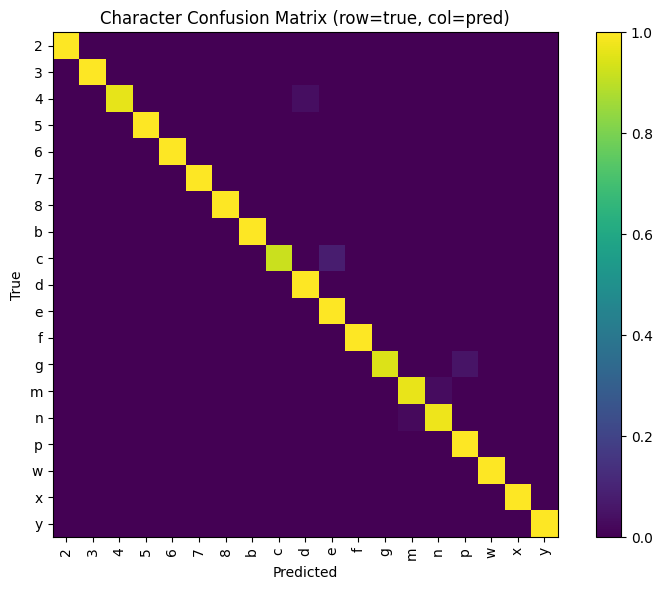


Per-character classification report:
              precision    recall  f1-score   support

           2     1.0000    1.0000    1.0000        27
           3     1.0000    1.0000    1.0000        31
           4     1.0000    0.9630    0.9811        27
           5     1.0000    1.0000    1.0000        20
           6     1.0000    1.0000    1.0000        15
           7     1.0000    1.0000    1.0000        38
           8     1.0000    1.0000    1.0000        31
           b     1.0000    1.0000    1.0000        32
           c     1.0000    0.9200    0.9583        25
           d     0.9643    1.0000    0.9818        27
           e     0.9231    1.0000    0.9600        24
           f     1.0000    1.0000    1.0000        33
           g     1.0000    0.9474    0.9730        19
           m     0.9677    0.9677    0.9677        31
           n     0.9762    0.9762    0.9762        42
           p     0.9615    1.0000    0.9804        25
           w     1.0000    1.0000    1.0000

In [144]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Character Confusion Matrix (row=true, col=pred)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(ticks=np.arange(len(vocab)), labels=vocab, rotation=90)
plt.yticks(ticks=np.arange(len(vocab)), labels=vocab)
plt.colorbar()
plt.tight_layout(); plt.show()

from sklearn.metrics import classification_report
print("\nPer-character classification report:")
print(classification_report(y_true_idx, y_pred_idx, target_names=vocab, digits=4))

---

#### Interpretation

- The **accuracy (≈ 98.8%)** reflects strong per-character recognition.  
- Slight performance drops for *c*, *e*, *g*, and *m/n* pairs indicate **shape similarity confusions** common in OCR systems.  
- The confusion heatmap visually supports these findings: off-diagonal purple squares mark such mismatches.

---

#### Key Takeaways
- **Diagonal dominance** → correct predictions vastly outnumber confusions.  
- **Per-character precision/recall** ensures that no single symbol class (digit or letter) disproportionately drives the accuracy score.  
- Combined, the heatmap and the classification report form a comprehensive **character-level diagnostic view** of the model’s decoding behavior.

#### WER at character-token level

WER counts substitutions + insertions + deletions divided by GT length—useful alongside CER

In [145]:
import difflib

def wer_char(gt: str, pr: str) -> float:
    sm = difflib.SequenceMatcher(a=list(gt), b=list(pr))
    subs = ins = dels = 0
    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag == "replace": subs += max(i2 - i1, j2 - j1)
        elif tag == "insert": ins += (j2 - j1)
        elif tag == "delete": dels += (i2 - i1)
    N = max(len(gt), 1)
    return (subs + ins + dels) / N

df_eval["wer"] = [wer_char(gt, pr) for gt, pr in zip(df_eval["label"], df_eval["pred"])]
print("Average WER:", df_eval["wer"].mean())

Average WER: 0.015384615384615385
